In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

%matplotlib inline

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [3]:
def save_model(classifier, stage, dataset, model_type, hz):
    '''
        Saves model to defined folder.

        stage - baseline/optimized
        dataset - base/centered/end/etc
        model_types - decision_tree, random_forest, ...
        hz - frequency
    '''

    import os
    import m2cgen as m2c
    
    BASE_PATH = f'models/{stage}/{dataset}/{model_type}/'
    FILE_NAME = f'{model_type}_{hz}hz.py'

    if not os.path.exists(BASE_PATH):
        os.makedirs(BASE_PATH)

    code = m2c.export_to_python(classifier)
    with open(BASE_PATH + FILE_NAME, 'w') as f:
        f.writelines(code)

In [4]:
def transform_data_for_inference(df):
    '''
        Transoforms dataset for inference.
        ms,acc,gyro -> acc_x_0, gyro_x_0, acc_x_10, gyro_x_10, .... acc_x_n, gyro_x_n
    '''

    df_list=[]

    for time in df.index:
        _df = pd.DataFrame(df.loc[time]).T
        # _df.drop('ms',axis=1, inplace=True)
        df_list.append(_df.add_suffix(f'_{str(int(time))}').reset_index(drop=True))

    return pd.concat(df_list, axis=1)


def get_filter_string(start, step):
    '''
        Creates a string to filter dataset for defined timetimestamps.
        To be used with df.filter(regex='<string returned from this functions>')
        Example: 0|50|100
    '''

    keep = np.arange(start, start+1+1000, step=int(step))
    return '|'.join(map(str, keep.astype(int)))


def line_color(inf_result):
    '''Returns color associated with inference result.'''
    colors = {
        1:'blue',
        2:'red',
        3:'green'
    }
    return colors[inf_result]


def downsample_df(df, period):
    '''Downsamples dataset.'''

    last_index_ms = df.index[-1]
    keep = np.arange(last_index_ms, step=period)

    return df.loc[keep]


def run_inference(df, model, start, step):
    '''Runs inference.'''
    regex_filter = get_filter_string(start=start, step=step)
    data = list(df.filter(regex=f'_({regex_filter})$').loc[0])
    return model.score(data)

def calculate_error(res, move_type):
    '''
        Calculates inference error rate in validation data.
    '''

    error_setup = {
        'circle': {'err_1':1,'err_2':2},
        'x':{'err_1':2, 'err_2':3},
        'y':{'err_1':1,'err_2':3}
    }

    err_1 = error_setup[move_type]['err_1']
    err_2 = error_setup[move_type]['err_2']

    val_counts = res['result'].value_counts().drop(0) # dropping `no movement`
    val_counts_keys = val_counts.keys()

    total_wrong = 0

    if err_1 in val_counts_keys:
        total_wrong += val_counts[err_1]
    if err_2 in val_counts_keys:
        total_wrong += val_counts[err_2]
    
    return (total_wrong / val_counts.sum()) * 100

In [5]:
def trainer_helper(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')

    return accuracy, f1, precision, recall, clf

In [6]:
def get_df_base(df):
    return df[(df['shift'] == 0)]

def get_df_center(df):
    df = df[
            ((df['label'] == 1) & (df['shift'] == -20))
            | ((df['label'] == 2) & (df['shift'] == -20))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 0) & (df['shift'] == 0))
        ]
    return df

def get_df_shift_aug(df):
    df = df[
            ((df['label'] == 1) & (df['shift'] <= -15))
            | ((df['label'] == 2) & (df['shift'] <= -15))
            | ((df['label'] == 3) & (df['shift'] == -2))
            | ((df['label'] == 3) & (df['shift'] == -1))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 3) & (df['shift'] == 1))
            | ((df['label'] == 3) & (df['shift'] == 2))
            | ((df['label'] == 0) & (df['shift'] > 1))
        ]
    return df

def get_df_end(df):
    df = df[
            ((df['label'] == 1) & (df['shift'] == -37))
            | ((df['label'] == 2) & (df['shift'] == -37))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 0) & (df['shift'] == 0))
        ]
    return df

In [7]:
def run_training(X_train,X_test, y_train, y_test, stage, dataset, hz, collect_time=False, is_save_model=False):
    collect_metrics = {}

    dt = DecisionTreeClassifier(random_state=42)
    rf = RandomForestClassifier(random_state=42, n_estimators=4)
    lsvc = LinearSVC(random_state=42, max_iter=10_000)
    lr = LogisticRegression(random_state=42, max_iter=10_000)

    model_setup = [
                    (dt, 'decision_tree'),
                    (rf,'random_forest'),
                    (lsvc, 'svc'),
                    (lr, 'logistic_regression')
                ]

    for item in model_setup:
        clf = item[0]
        name = item[1]

        collect_metrics[name] = {}

        print('\n')
        print(f'{name} {hz} Hz')

        accuracy, f1, precision, recall, model = trainer_helper(clf, X_train, X_test, y_train, y_test)

        collect_metrics[name] = {
                'accuracy':accuracy,
                'f1':f1,
                'precision':precision,
                'recall':recall}

        if collect_time:
            test_data = [X_train.iloc[0]]
            inf_time = get_ipython().run_line_magic('timeit', '-o model.predict(test_data)')
            collect_metrics[name]['time'] = inf_time.timings

        if is_save_model:
            save_model(model, stage, dataset, name, hz)

    return collect_metrics

In [9]:
res = {}

for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = get_df_base(df)
    df_train = df_train.dropna(axis=0)


    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset='base',
                    hz=hz,
                    collect_time=True,
                    is_save_model=True
                    )

    res[hz] = results


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz
67.6 µs ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


random_forest 10 Hz
596 µs ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


svc 10 Hz
57.3 µs ± 439 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


logistic_regression 10 Hz
57.8 µs ± 603 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz
64.8 µs ± 530 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


random_forest 20 Hz
590 µs ± 6.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


svc 20 Hz
58.3 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


logistic_regression 20 Hz
58.6 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Training on dataset with 25 Hz
******

In [10]:
res_df = pd.DataFrame(res)
res_df_acc = res_df.applymap(lambda x: x['accuracy'])
res_df_acc = res_df_acc.T.reset_index()
res_df_acc = res_df_acc.melt(id_vars=['index']).rename(columns={'variable':'model','value':'accuracy','index':'hz'})
res_df_acc.to_csv('output/baseline_model_accuracy.csv', index=False)

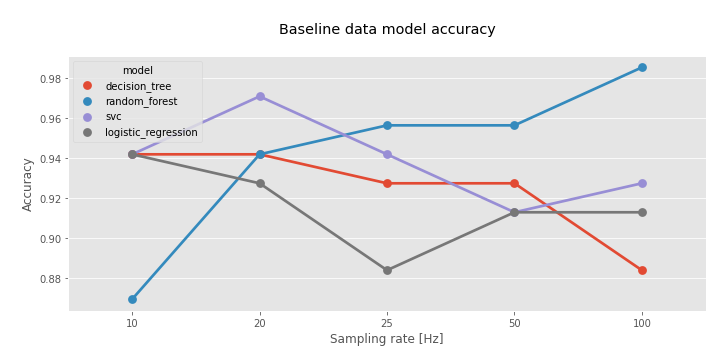

In [11]:
plt.figure(figsize=(10,5))
sns.pointplot(data=res_df_acc, x='hz', y='accuracy', hue='model', marker='o')
plt.title('\nBaseline data model accuracy\n');
plt.ylabel('\nAccuracy')
plt.xlabel('Sampling rate [Hz]')
plt.tight_layout()

In [12]:
from models.baseline.base.decision_tree import decision_tree_10hz, decision_tree_20hz, decision_tree_25hz, decision_tree_50hz, decision_tree_100hz
from models.baseline.base.random_forest import random_forest_10hz, random_forest_20hz, random_forest_25hz, random_forest_50hz, random_forest_100hz
from models.baseline.base.svc import svc_10hz, svc_20hz, svc_25hz, svc_50hz, svc_100hz
from models.baseline.base.logistic_regression import logistic_regression_10hz, logistic_regression_20hz, logistic_regression_25hz, logistic_regression_50hz, logistic_regression_100hz


In [13]:
test_data_10hz = pd.read_csv('data/transformed/20210529_v2_data_all_10hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_20hz = pd.read_csv('data/transformed/20210529_v2_data_all_20hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_25hz = pd.read_csv('data/transformed/20210529_v2_data_all_25hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_50hz = pd.read_csv('data/transformed/20210529_v2_data_all_50hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_100hz = pd.read_csv('data/transformed/20210529_v2_data_all_100hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]


In [14]:
test_data_10hz.shape, test_data_20hz.shape, test_data_25hz.shape, test_data_50hz.shape, test_data_100hz.shape


((66,), (126,), (156,), (306,), (606,))

In [15]:
from statistics import mean

m2c_time_test_setup = {
    'decision_tree': [
        (decision_tree_10hz, test_data_10hz, 10),
        (decision_tree_20hz, test_data_20hz, 20),
        (decision_tree_25hz, test_data_25hz, 25),
        (decision_tree_50hz, test_data_50hz, 50),
        (decision_tree_100hz, test_data_100hz, 100)
    ],
    'random_forest': [
        (random_forest_10hz, test_data_10hz, 10),
        (random_forest_20hz, test_data_20hz, 20),
        (random_forest_25hz, test_data_25hz, 25),
        (random_forest_50hz, test_data_50hz, 50),
        (random_forest_100hz, test_data_100hz, 100)
    ],
    'svc': [
        (svc_10hz, test_data_10hz, 10),
        (svc_20hz, test_data_20hz, 20),
        (svc_25hz, test_data_25hz, 25),
        (svc_50hz, test_data_50hz, 50),
        (svc_100hz, test_data_100hz, 100)
    ],
    'logistic_regression': [
        (logistic_regression_10hz, test_data_10hz, 10),
        (logistic_regression_20hz, test_data_20hz, 20),
        (logistic_regression_25hz, test_data_25hz, 25),
        (logistic_regression_50hz, test_data_50hz, 50),
        (logistic_regression_100hz, test_data_100hz, 100)
    ]
}

m2c_time_data = {}            

for k, v in m2c_time_test_setup.items():
    m2c_time_data[k] = {}
    for t_item in v:
        model = t_item[0]
        test_data = t_item[1]
        freq = t_item[2]
        res_time = get_ipython().run_line_magic('timeit', '-o model.score(test_data)')

        m2c_time_data[k][freq] = mean(res_time.timings)

6.48 µs ± 74.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.89 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.77 µs ± 17.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.79 µs ± 28.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.24 µs ± 12.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
29.9 µs ± 223 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
31.7 µs ± 669 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
28 µs ± 847 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
32.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
26.6 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
457 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
852 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.04 ms ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.09 ms ± 70.5 µs per loop (mean ± std. dev. o

In [16]:
m2c_time_df = pd.DataFrame(m2c_time_data)
skl_time_df = res_df.applymap(lambda x: mean(x['time'])).T

In [17]:
m2c_time_df['framework'] = 'pure-python'
skl_time_df['framework'] = 'scikit'
inf_time_df = pd.concat([m2c_time_df, skl_time_df]).reset_index().rename(columns={'index':'hz'})
inf_time_df.to_csv('output/baseline_model_inference_time.csv', index=False)


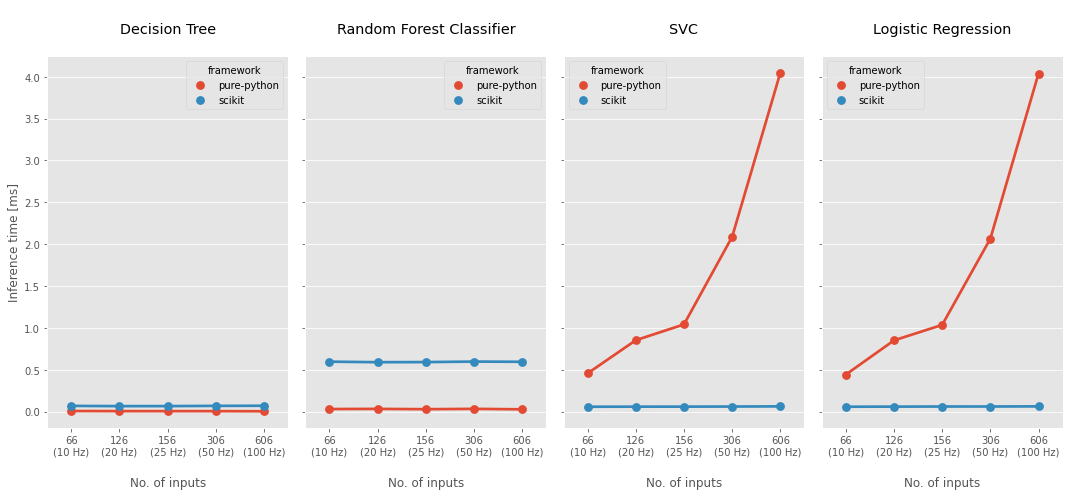

In [18]:
import matplotlib.ticker as tick

fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(15,7))
plt.title('Inference times')

sns.pointplot(x='hz', y='decision_tree', hue='framework', data=inf_time_df[['decision_tree','framework','hz']], ax=ax[0])
sns.pointplot(x='hz', y='random_forest', hue='framework', data=inf_time_df[['random_forest','framework','hz']], ax=ax[1])
sns.pointplot(x='hz', y='svc', hue='framework', data=inf_time_df[['svc','framework','hz']], ax=ax[2])
sns.pointplot(x='hz', y='logistic_regression', hue='framework', data=inf_time_df[['logistic_regression','framework','hz']], ax=ax[3])

ax[0].title.set_text('\nDecision Tree\n')
ax[0].set_ylabel('Inference time [ms]')
ax[0].set_xticklabels(['66\n(10 Hz)', '126\n(20 Hz)', '156\n(25 Hz)', '306\n(50 Hz)', '606\n(100 Hz)'])
ax[0].set_xlabel('\nNo. of inputs')

ax[1].title.set_text('\nRandom Forest Classifier\n')
ax[1].set_ylabel('')
ax[1].set_xticklabels(['66\n(10 Hz)', '126\n(20 Hz)', '156\n(25 Hz)', '306\n(50 Hz)', '606\n(100 Hz)'])
ax[1].set_xlabel('\nNo. of inputs')

ax[2].title.set_text('\nSVC\n')
ax[2].set_ylabel('')
ax[2].set_xticklabels(['66\n(10 Hz)', '126\n(20 Hz)', '156\n(25 Hz)', '306\n(50 Hz)', '606\n(100 Hz)'])
ax[2].set_xlabel('\nNo. of inputs')

ax[3].title.set_text('\nLogistic Regression\n')
ax[3].set_ylabel('')
ax[3].set_xticklabels(['66\n(10 Hz)', '126\n(20 Hz)', '156\n(25 Hz)', '306\n(50 Hz)', '606\n(100 Hz)'])
ax[3].set_xlabel('\nNo. of inputs')

plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x, post: f'{(x * 1000)}'))
plt.tight_layout()

In [19]:
from models.baseline.base.decision_tree import decision_tree_100hz, decision_tree_50hz, decision_tree_25hz, decision_tree_20hz, decision_tree_10hz
from models.baseline.base.random_forest import random_forest_100hz, random_forest_50hz, random_forest_25hz, random_forest_20hz, random_forest_10hz

model_setups = [
    (decision_tree_100hz, 100, (0,0), 'decision_tree'),
    (decision_tree_50hz, 50, (0,1), 'decision_tree'),
    (decision_tree_25hz, 25, (0,2), 'decision_tree'),
    (decision_tree_20hz, 20, (0,3), 'decision_tree'),
    (decision_tree_10hz, 10, (0,4), 'decision_tree'),
    (random_forest_100hz, 100, (1,0), 'random_forest'),
    (random_forest_50hz, 50, (1,1), 'random_forest'),
    (random_forest_25hz, 25, (1,2), 'random_forest'),
    (random_forest_20hz, 20, (1,3), 'random_forest'),
    (random_forest_10hz, 10, (1,4), 'random_forest')
]

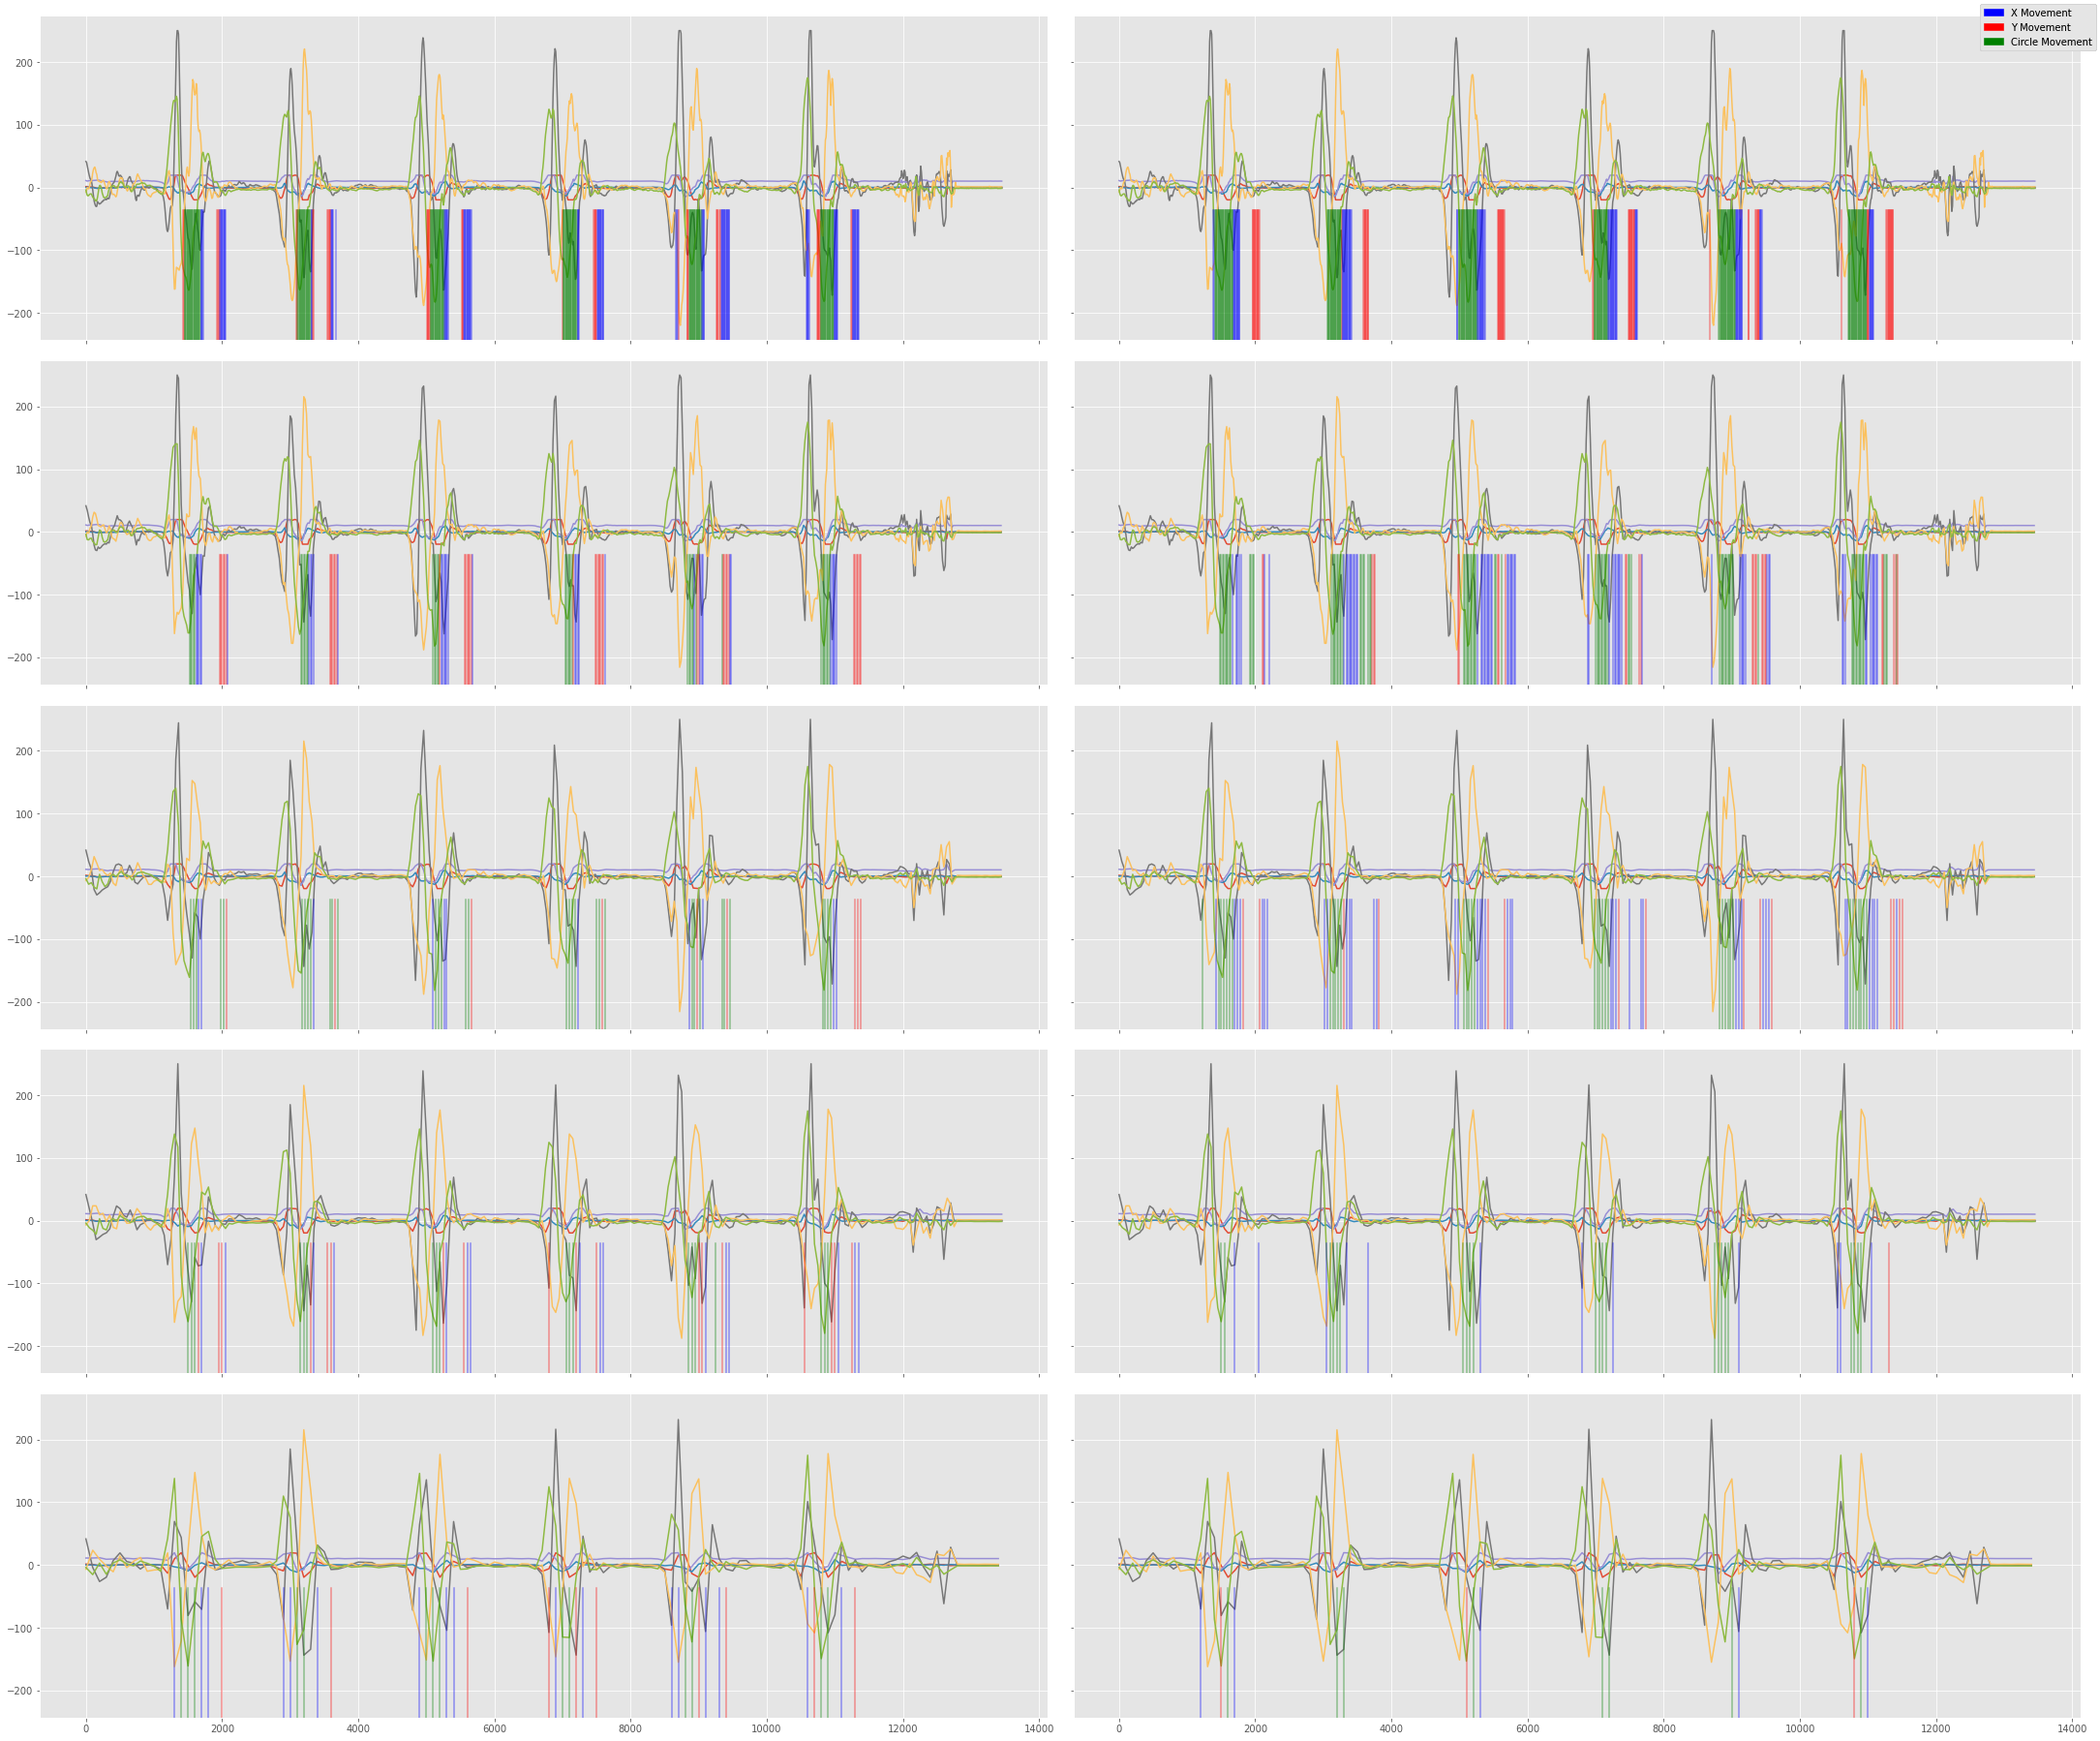

In [20]:
validation_results_circle = []

fig, ax = plt.subplots(ncols=2, nrows=5, sharey=True, sharex=True, figsize=(30,25))
fig.tight_layout()

for setup in model_setups:
    MODEL = setup[0]
    FREQ = setup[1]
    STEP = (1000 / FREQ)
    COL = setup[2][0]
    ROW = setup[2][1]

    df_val = pd.read_csv('data/validation/move_circle_20210522_1.csv').set_index('ms')

    # initialize empty dataset to collect results
    inf_results = pd.DataFrame([],columns=['start','end','result'])

    # treat dataset 
    df_downsampled = downsample_df(df_val, STEP) # downsample dataset
    df_inference = transform_data_for_inference(df_downsampled) # converts dataset to inference format

    # Plot signals
    ax[ROW][COL].plot(df_downsampled)

    # generate a list of steps    
    inference_step = list(np.arange(0, df_val.index[-1] + 1 - 1010, step=STEP))

    for st in inference_step:
        res = np.argmax(run_inference(df_inference, MODEL, st, STEP))
        inf_results = pd.concat([inf_results, pd.DataFrame([{'start':st,'end':st+1000,'result':res}])], axis=0)

        if res in [1,2,3]:
            color = line_color(res)
            ax[ROW][COL].axvline(x=st+500, ymin=0, ymax=0.4, color=color, alpha=0.4)

    # Create Legend
    blue_patch = mpatches.Patch(color='blue', label='X Movement')
    red_patch = mpatches.Patch(color='red', label='Y Movement')
    green_patch = mpatches.Patch(color='green', label='Circle Movement')
    fig.legend(handles=[blue_patch, red_patch, green_patch])


    # get error rate
    wrong_percentage = calculate_error(inf_results, 'circle')

    validation_results_circle.append({'model':setup[-1], 'hz':setup[1], 'wrong_percentage': wrong_percentage, 'value_counts': inf_results['result'].value_counts()})


In [21]:
res_no_shift_circle_df = pd.DataFrame(res_no_shift_circle)
sns.pointplot(data=res_no_shift_circle_df, x='hz', y='wrong_percentage', hue='model');


NameError: name 'res_no_shift_circle' is not defined